In [1]:
import numpy as np
import pandas as pd
import zipfile
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D , Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from keras.applications import VGG16
from keras import optimizers
from keras.models import Model
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


# Kết nối với gg drive

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
filenames = os.listdir("gdrive/MyDrive/image/train/train")
categories=[]

for filename in filenames:
    category = filename.split('.')[0]
    
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

df.head()

filename  category
0    cat.19.jpg         0
1  cat.1907.jpg         0
2  cat.1908.jpg         0
3  cat.1936.jpg         0
4  cat.1927.jpg         0

In [4]:
df.dtypes

filename    object
category     int64
dtype: object

<Axes: >

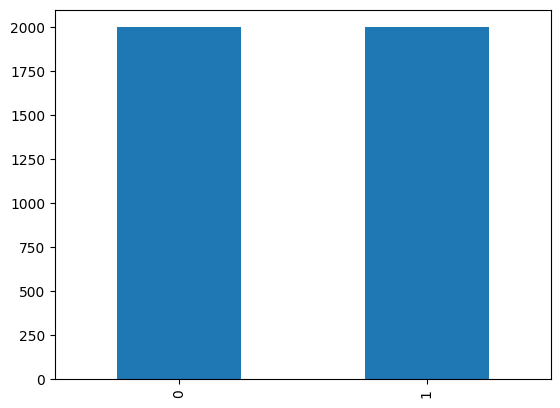

In [5]:
df['category'].value_counts().plot.bar()

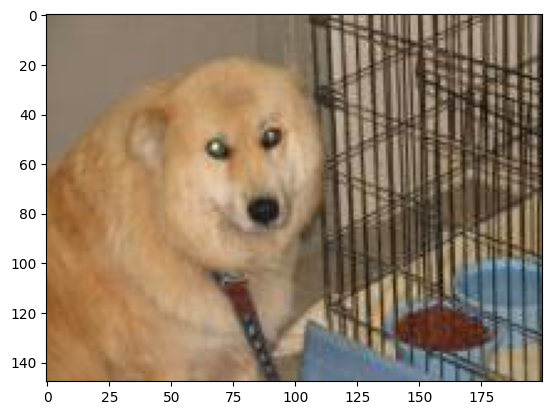

In [6]:
import random
sample = random.choice(filenames)
img = np.asarray(Image.open("gdrive/MyDrive/image/train/train/" + sample))
# image = load_img()
plt.imshow(img)

In [7]:
train_df, validate_df = train_test_split(df, test_size=0.2)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()


total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

validate_df

index      filename  category
0     3804  dog.1725.jpg         1
1     3256  dog.1228.jpg         1
2     1173  cat.1153.jpg         0
3     1898   cat.181.jpg         0
4     1017  cat.1011.jpg         0
..     ...           ...       ...
795   2641   dog.678.jpg         1
796   2297   dog.367.jpg         1
797   2426   dog.478.jpg         1
798   2137   dog.219.jpg         1
799   1864  cat.1754.jpg         0

[800 rows x 3 columns]

In [8]:
train_df['category']=train_df['category'].astype(str)
validate_df['category']=validate_df['category'].astype(str)

In [9]:
image_size = 224
input_shape = (image_size, image_size, 3)
epochs = 10
batch_size = 16

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "gdrive/MyDrive/image/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 2 classes.


# Validation Image Generator

In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "gdrive/MyDrive/image/train/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


# Sample Images Generated

Found 1 validated image filenames belonging to 1 classes.


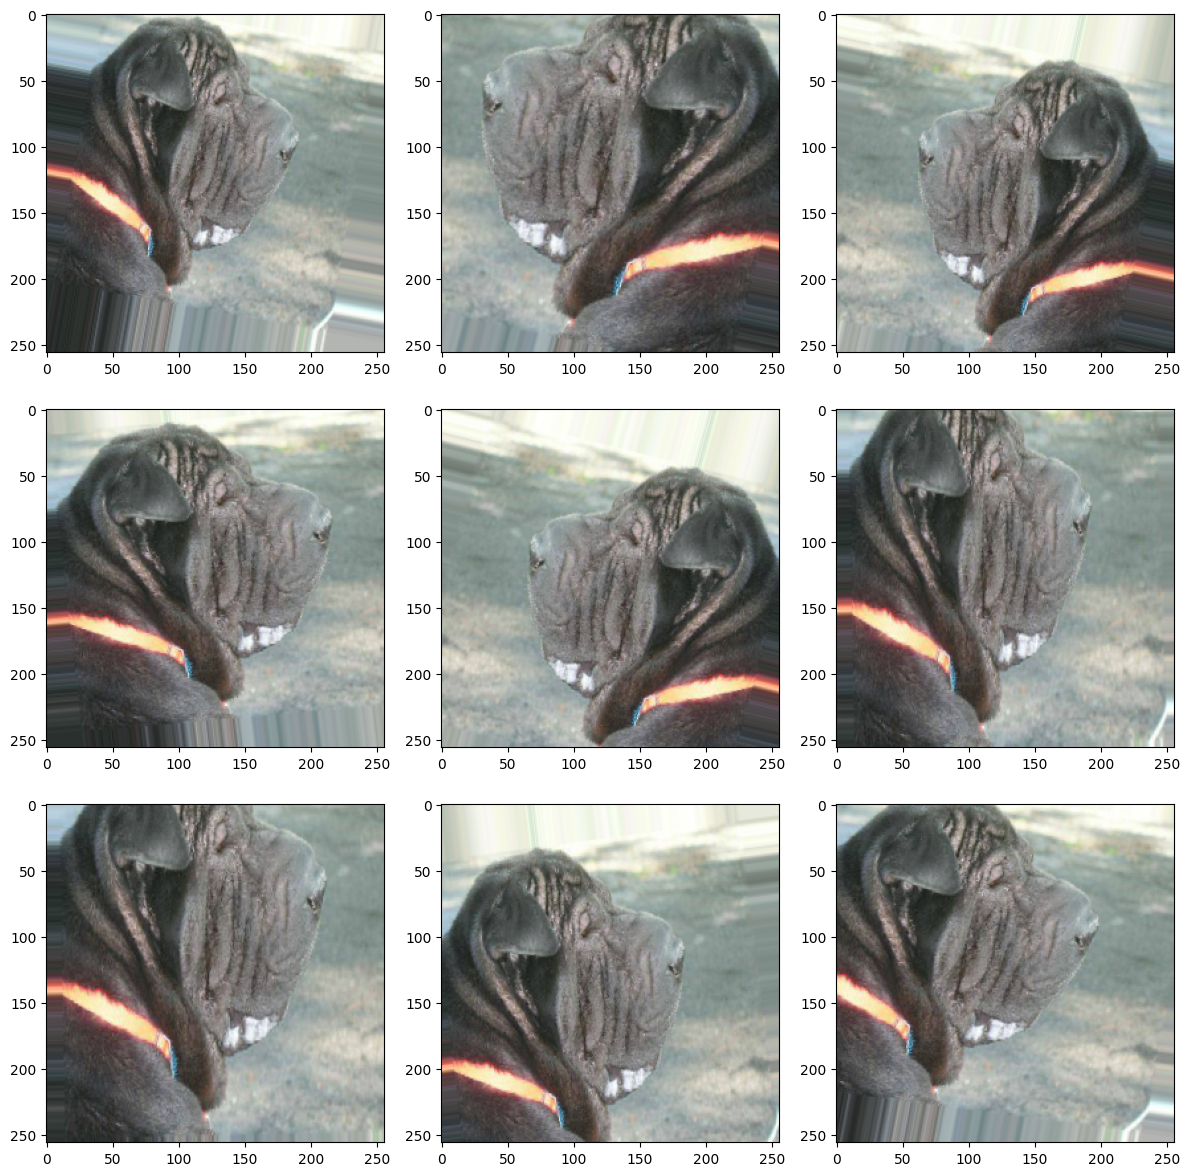

In [11]:
example_df = train_df.sample(n=1).reset_index(drop = True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "gdrive/MyDrive/image/train/train/",
    x_col='filename',
    y_col='category',
    class_mode='categorical'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Model

In [12]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


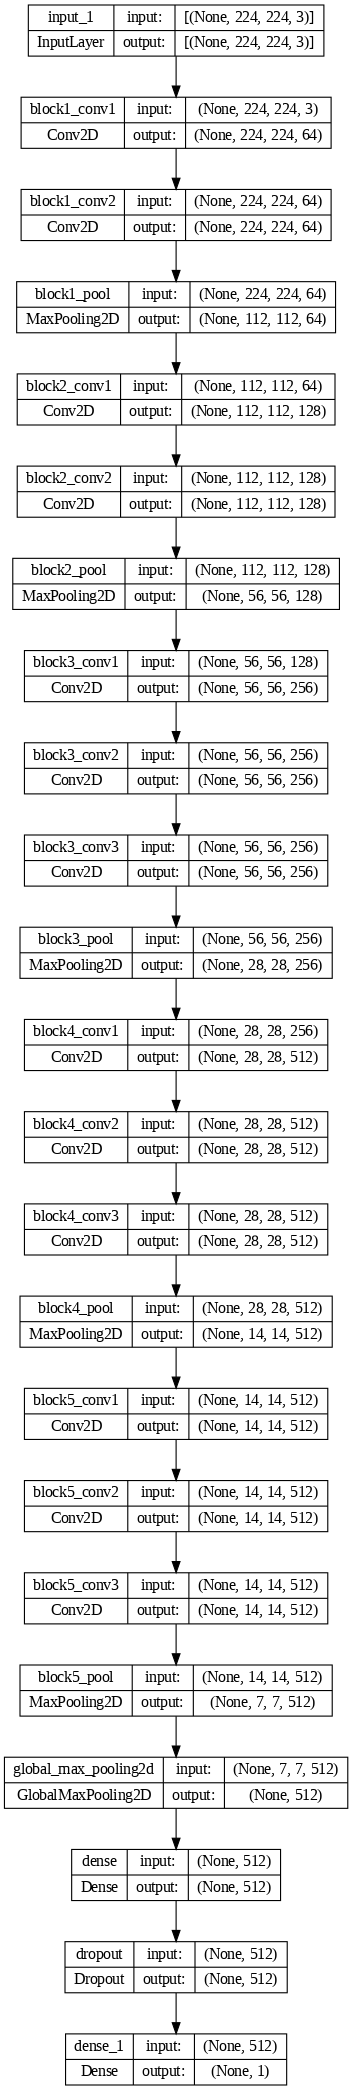

In [13]:
from keras.utils import plot_model
plot_model(model, show_shapes = True,expand_nested = True,dpi = 80)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 14.7 MB/s eta 0:00:00


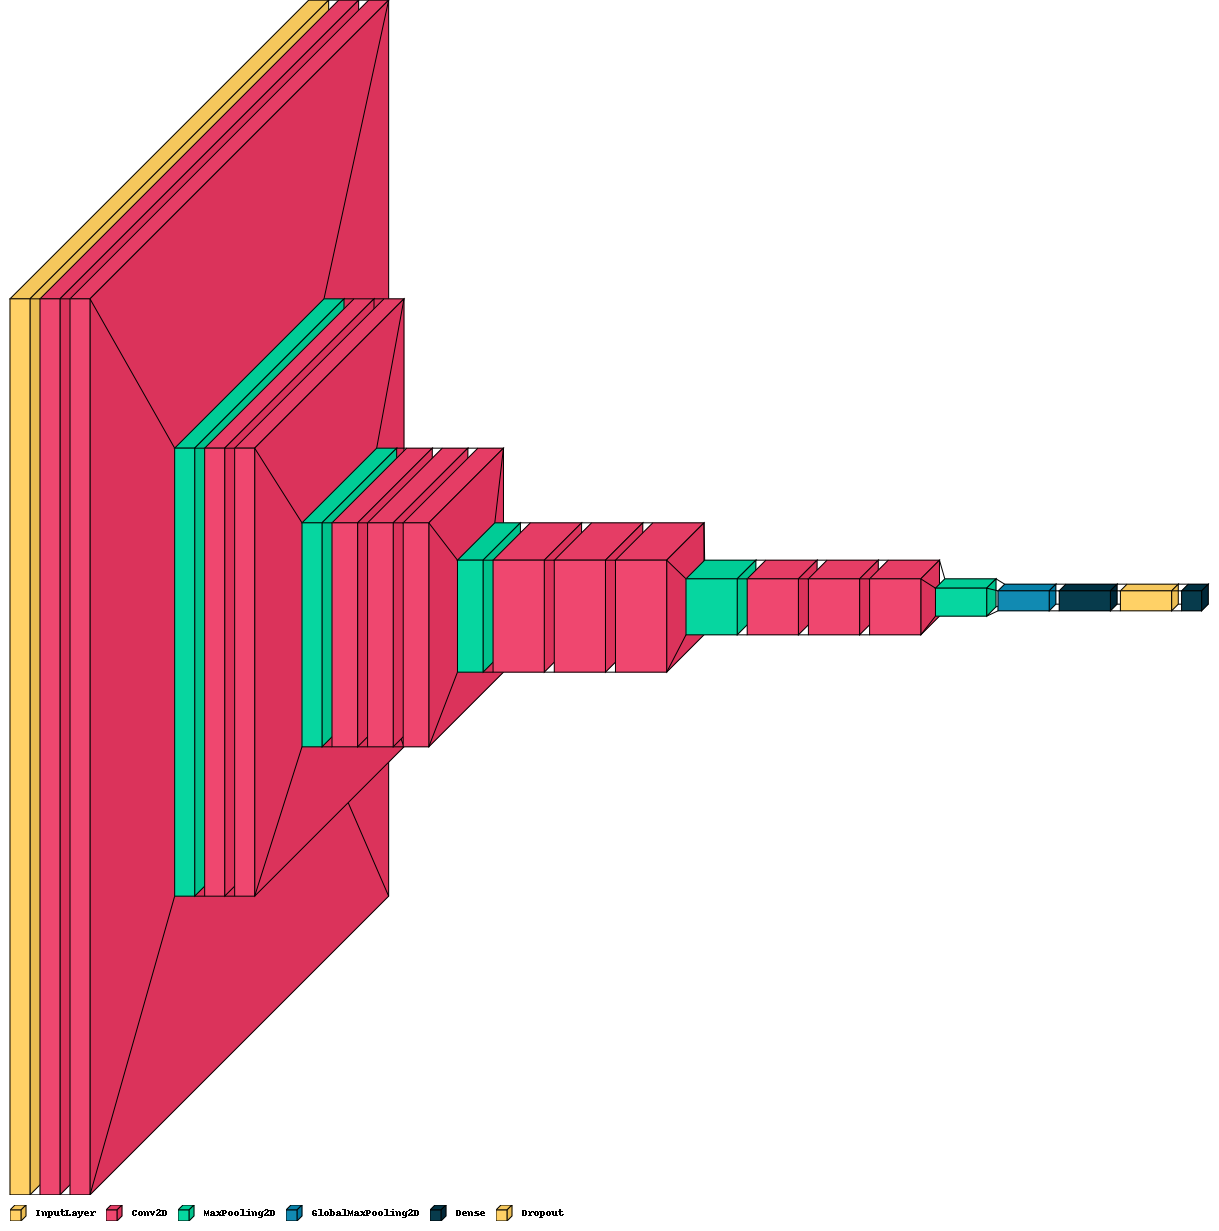

In [14]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) 

# Fit model

In [15]:
# fine-tune the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/5
200/200 [==============================] - 3134s 16s/step - loss: 0.6145 - accuracy: 0.6641 - val_loss: 0.3342 - val_accuracy: 0.8850
Epoch 2/5
200/200 [==============================] - 3064s 15s/step - loss: 0.3458 - accuracy: 0.8409 - val_loss: 0.1975 - val_accuracy: 0.9262
Epoch 3/5
200/200 [==============================] - 2993s 15s/step - loss: 0.2514 - accuracy: 0.8947 - val_loss: 0.1546 - val_accuracy: 0.9400
Epoch 4/5
200/200 [==============================] - 3064s 15s/step - loss: 0.2116 - accuracy: 0.9091 - val_loss: 0.1351 - val_accuracy: 0.9488
Epoch 5/5
200/200 [==============================] - 3065s 15s/step - loss: 0.1778 - accuracy: 0.9262 - val_loss: 0.1237 - val_accuracy: 0.9475


In [17]:
loss, accuracy = model.evaluate(train_generator, verbose=1)
print("Train : accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss_v, accuracy_v = model.evaluate(validation_generator, verbose=1)
print("Validation : accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))


200/200 [==============================] - 2081s 10s/step - loss: 0.1449 - accuracy: 0.9444
Train : accuracy = 0.944375  ;  loss = 0.144865
50/50 [==============================] - 513s 10s/step - loss: 0.1237 - accuracy: 0.9475
Validation : accuracy = 0.947500  ;  loss_v = 0.123654


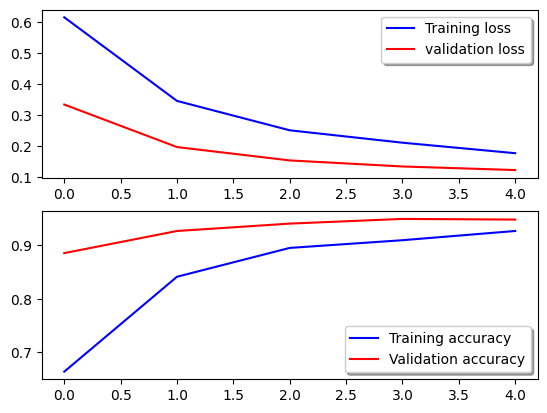

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# Testing *Data*

In [19]:
test_filenames = os.listdir("gdrive/MyDrive/image/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]



# Test generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "gdrive/MyDrive/image/test1/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)



predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

Found 600 validated image filenames.


<ipython-input-19-79a9fb1cc20a>:24: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


# Result

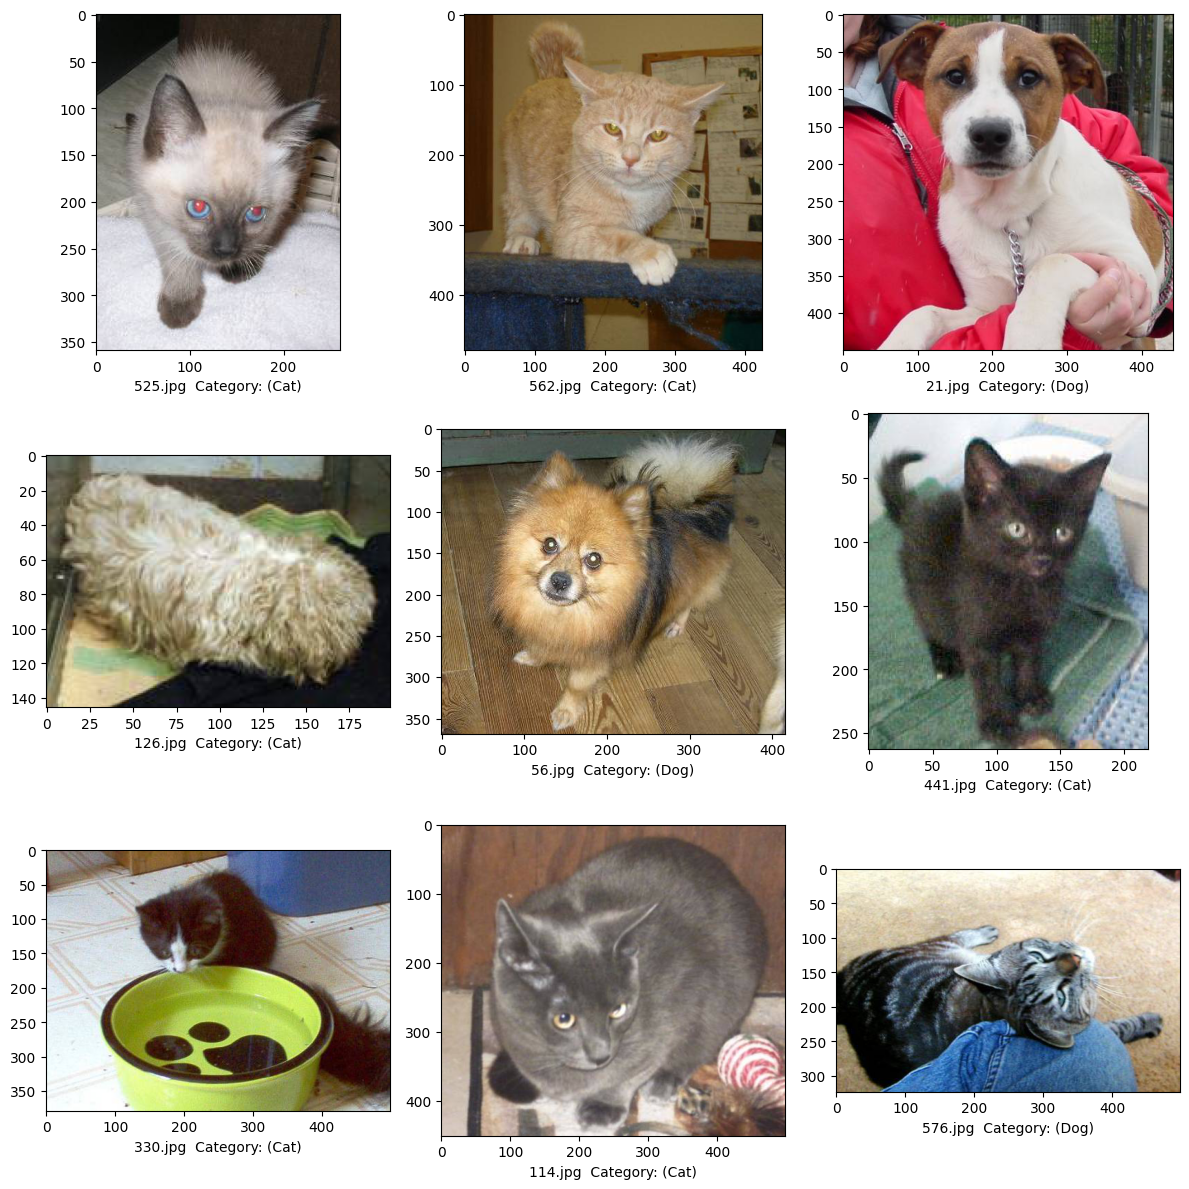

In [21]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = 'Cat'if row['category']==0 else 'Dog'
    img = np.asarray(Image.open("gdrive/MyDrive/image/test1/test1/"+ filename))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '  Category: (' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()